### Getting the dataset

I have created a mixed dataset using the ExpW and the FER+ datasets. Combined, we have a total of 120710 images, divided in 7 emotion groups (anger,disgust,fear,happiness,neutral,sadness and surprise). Train and test groups are defined in a stratified 80/20 ratio.

In [ ]:
import os
from zipfile import ZipFile

In [ ]:
if os.path.exists('../data/mixed_dataset.zip'):
    pass
else:
    !pip install gdown --quiet
    import gdown
    url_zip = 'https://drive.google.com/uc?id=1toh7GhPI8aSobYyGmyzaP0jB2TFp11St'
    output_zip = '../data/mixed_dataset.zip'
    gdown.download(url_zip, output_zip, quiet=False)

In [ ]:
file_name = '../data/mixed_dataset.zip'

with ZipFile(file_name, 'r') as zip:
    zip.extractall(path='../data/')
    print('Done')

Done


In [ ]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2

The mixed dataset has 48x48 images, but after continuous testing, I have decided to allow a bigger image size.
It will impact on model size and response times, but for now, this decision brings better predictions since we have more pixels to make the analysis. And since the ExpW use color images, we will keep the RGB color range.

In [ ]:
train_img_datagen = ImageDataGenerator(rescale=1./255)
val_img_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_img_datagen.flow_from_directory('../data/train',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical')

val_set = val_img_datagen.flow_from_directory('../data/test',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical')

Found 96569 images belonging to 7 classes.
Found 24141 images belonging to 7 classes.


In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')

After a few tries I have decided to retrain the model.

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, '-', layer.trainable)

0 input_2 - True
1 conv1_pad - True
2 conv1_conv - True
3 conv1_bn - True
4 conv1_relu - True
5 pool1_pad - True
6 pool1_pool - True
7 conv2_block1_1_conv - True
8 conv2_block1_1_bn - True
9 conv2_block1_1_relu - True
10 conv2_block1_2_conv - True
11 conv2_block1_2_bn - True
12 conv2_block1_2_relu - True
13 conv2_block1_0_conv - True
14 conv2_block1_3_conv - True
15 conv2_block1_0_bn - True
16 conv2_block1_3_bn - True
17 conv2_block1_add - True
18 conv2_block1_out - True
19 conv2_block2_1_conv - True
20 conv2_block2_1_bn - True
21 conv2_block2_1_relu - True
22 conv2_block2_2_conv - True
23 conv2_block2_2_bn - True
24 conv2_block2_2_relu - True
25 conv2_block2_3_conv - True
26 conv2_block2_3_bn - True
27 conv2_block2_add - True
28 conv2_block2_out - True
29 conv2_block3_1_conv - True
30 conv2_block3_1_bn - True
31 conv2_block3_1_relu - True
32 conv2_block3_2_conv - True
33 conv2_block3_2_bn - True
34 conv2_block3_2_relu - True
35 conv2_block3_3_conv - True
36 conv2_block3_3_bn - True
37

In [ ]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(7,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

In [ ]:
try: 
    os.mkdir('../models/checkpoint')
except:
    pass

In [ ]:
file_name = 'best_model_tl_224x224.h5'
checkpoint_path = os.path.join('../models/checkpoint',file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_accuracy', 
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True, 
                                                 save_weights_only=False, 
                                                 mode='max')

In [ ]:
model_info = model.fit(train_set, steps_per_epoch=500, epochs=24, validation_data=val_set,validation_steps=220,callbacks=call_back)
#model_info = model.fit(train_set,epochs=100, validation_data=val_set,callbacks=call_back)

Epoch 1/24
500/500 [==============================] - 196s 382ms/step - loss: 1.2821 - accuracy: 0.5407 - val_loss: 1.7123 - val_accuracy: 0.3092

Epoch 00001: val_accuracy improved from -inf to 0.30916, saving model to ../models/checkpoint/best_model_tl_224x224.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/24
500/500 [==============================] - 190s 381ms/step - loss: 1.0827 - accuracy: 0.6131 - val_loss: 1.1373 - val_accuracy: 0.5903

Epoch 00002: val_accuracy improved from 0.30916 to 0.59027, saving model to ../models/checkpoint/best_model_tl_224x224.h5
Epoch 3/24
500/500 [==============================] - 190s 381ms/step - loss: 1.0298 - accuracy: 0.6298 - val_loss: 1.3655 - val_accuracy: 0.5237

Epoch 00003: val_accuracy did not improve from 0.59027
Epoch 4/24
500/500 [==============================] - 190s 381ms/step - loss: 0.9864 - accuracy: 0.6492 - val_loss: 1.0571 - val_accuracy: 0.6248

Epoch 00004: val_accuracy improved from 0.59027 to 0.62479, saving model to ../models/checkpoint/best_model_tl_224x224.h5
Epoch 5/24
500/500 [==============================] - 190s 381ms/step - loss: 0.9547 - accuracy: 0.6592 - val_loss: 1.1001 - val_accuracy: 0.6006

Epoch 00005: val_accuracy did not improve from 0.62479
Epoch 6/24
500/500 [==============================] - 190s

In [ ]:
 #Saving the model
model.save('../models/model_tl_full_224x224.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# plots accuracy and loss curves
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


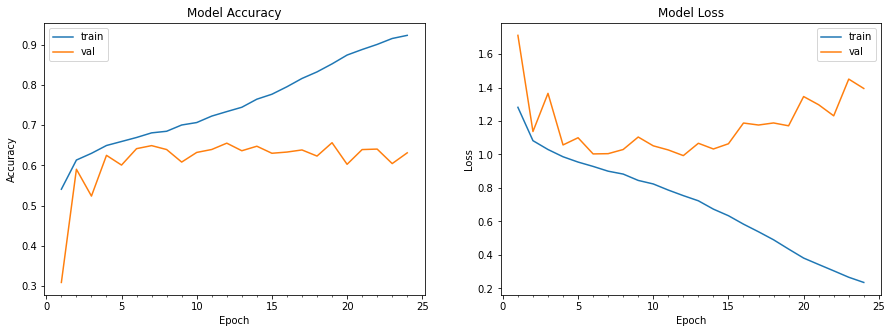

In [ ]:
plot_model_history(model_info)

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2021-07-19 13:24:52--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.04s   

2021-07-19 13:24:52 (23.5 MB/s) - ‘haarcascade_frontalface_default.xml.1’ saved [930127/930127]



In [ ]:
url_photo = 'https://drive.google.com/uc?id=1DJbwLlPei5CDA-ooFsFot7dkvRv7oCzO'
output_photo = 'photo.jpg'
gdown.download(url_photo, output_photo, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1DJbwLlPei5CDA-ooFsFot7dkvRv7oCzO
To: /content/photo.jpg
100%|██████████| 53.9k/53.9k [00:00<00:00, 17.8MB/s]


'photo.jpg'

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('../models/model_tl_full_224x224.h5')

In [ ]:
validation_generator = val_img_datagen.flow_from_directory(
        '../data/test',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 24141 images belonging to 7 classes.
{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [ ]:
def emotion_predict(emotions):
    objects=('anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness','surprise')
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    plt.show()

In [ ]:
def facecrop(image):
    facedata='haarcascade_frontalface_default.xml'
    cascade=cv2.CascadeClassifier(facedata)
    
    img = cv2.imread(image)
    
    try:
        
        minisize=(img.shape[1],img.shape[0])
        miniframe=cv2.resize(img,minisize)
        
        faces=cascade.detectMultiScale(miniframe)
        
        for f in faces:
            x,y,w,h = [v for v in f]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
            
            sub_face = img[y:y+h, x:x+w]
            
            cv2.imwrite('capture.jpg', sub_face)
            print ('Writing: ' + image)
    
    except Exception as e:
        print (e)

In [ ]:
facecrop('photo.jpg')

Writing: photo.jpg


Writing: photo.jpg


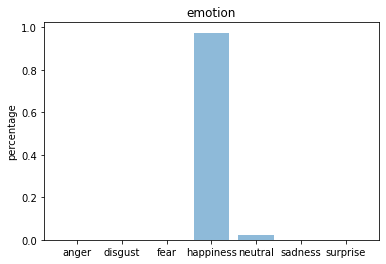

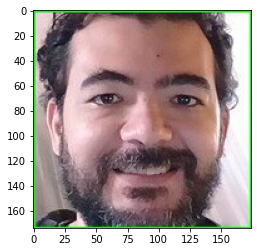

In [ ]:
if __name__ == '__main__':
    facecrop('photo.jpg')
    
#Testing

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

file = 'capture.jpg'
true_image = image.load_img(file)
#img = image.load_img(file, color_mode='grayscale', target_size=(48,48))
img = image.load_img(file, target_size=(224,224,3))

x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)

x /= 255

custom = model.predict(x)
emotion_predict(custom[0])

x = np.array(x, 'float32')
x = x.reshape([224,224,3])
plt.imshow(true_image)
plt.show()